In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import os, re, glob2, pickle

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# image_path = '/home/esoroush/Datasets/cifar10/train/'
image_path = '/media/data/temps/flash/faraadid/'
model_dir = '/home/esoroush/models/tensorflow'
num_top_predictions = 5


In [3]:
def create_graph():
    
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(os.path.join(
      model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    
def run_inference_on_image(image):
    
    """Runs forward path on an image.
    Args:
    image: Image file name.

    Returns:
    off the shelf 2048 feature vector
    """
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()


    with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
        pool3 = sess.graph.get_tensor_by_name('pool_3:0')
        features = sess.run(pool3,
                               {'DecodeJpeg/contents:0': image_data})
        return features


In [5]:
no_of_images=1600
features = np.zeros([no_of_images, 2048])
image_names = glob2.glob(image_path + "**/*.png")
np.random.seed(3)
np.random.shuffle(image_names)
image_names = image_names[:no_of_images]

In [14]:
# Creates graph from saved GraphDef.
create_graph()
feature_filename = '%s-tsne-feature-images-%d.p'%(image_path.split('/')[-2], no_of_images)
if os.path.exists(feature_filename):
    with open(feature_filename, 'rb') as f:
        features, image_names = pickle.load(f)
else:
    for i in xrange(no_of_images):
        print('image name: %s index: %d/%d' %(image_names[i], i, no_of_images))
        features[i, :] = run_inference_on_image(image=image_names[i]).squeeze()
    with open(feature_filename, 'wb') as f:
        pickle.dump((features, image_names), f)

In [28]:
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
reduced_transformed *= (int(np.sqrt(no_of_images))-1)

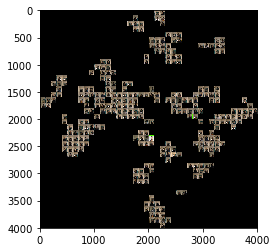

In [35]:
def zigzag(n):
    indexorder = sorted(((x,y) for x in range(n) for y in range(n)),
                    key = lambda (x,y): (x+y, -y if (x+y) % 2 else y) )
    return indexorder
ellipside = True
image_width = 100
merged_width = int(np.sqrt(no_of_images)*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')
zigzag_indexes = zigzag(int(np.sqrt(no_of_images)))
nn = NearestNeighbors(n_neighbors=no_of_images, algorithm='ball_tree')
if ellipside:
    nn.fit(zigzag_indexes)
    distances, indices = nn.kneighbors(reduced_transformed)
else:
    nn.fit(reduced_transformed)
    distances, indices = nn.kneighbors(zigzag_indexes)
    
min_distances = np.argsort(np.min(distances, axis=1))

for counter, index in enumerate(min_distances):
    # set location
    if ellipside:
        i = indices[index, np.argmin(distances[index, :])]
        a = zigzag_indexes[i]
        image_address = image_names[counter]
    else:
        a = zigzag_indexes[counter]
        image_index = indices[index, np.argmin(distances[index, :])]
        image_address = image_names[image_index]
        distances[indices==image_index] = np.finfo(np.float32).max
        indices[indices==image_index] = np.finfo(np.float32).max
    image = np.asarray(Image.open(image_address).resize((image_width, image_width)))
    merged_image[a[0]*image_width:(a[0]+1)*image_width, a[1]*image_width:(a[1]+1)*image_width,:] = image[:,:,:3]

plt.imshow(merged_image)
plt.show()
merged_image = Image.fromarray(merged_image)
if ellipside:
    merged_image.save('merged-%s-ellipside.png'%image_path.split('/')[-2])
else:
    merged_image.save('merged-%s.png'%image_path.split('/')[-2])
